In [1]:
import torch
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from tracr.haiku_to_pytorch import haiku_to_pytorch, apply
from torchinfo import summary

from rasp_models.peak import get_peak_model
from datasets.dataloaders import makePeakDataLoader

In [2]:
loader = makePeakDataLoader()

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = get_peak_model()
torch_model = haiku_to_pytorch(model).to(DEVICE)

In [4]:
def evaluate(model, data):
    inputs, outputs = data[0]

    model_output = model.forward(inputs)

    if torch.isnan(sum(sum(sum(model_output)))):
        print(inputs)
        print(outputs)
        print(model_output)

    loss = F.cross_entropy(model_output, outputs)
    return loss, {
        "logits": model_output
    }

In [5]:
summary(torch_model)

Layer (type:depth-idx)                   Param #
TracrTransformer                         --
├─ModuleList: 1-1                        --
│    └─TracrBlock: 2-1                   --
│    │    └─TracrAttention: 3-1          248,025
│    │    └─TracrMLP: 3-2                121,677
│    └─TracrBlock: 2-2                   --
│    │    └─TracrAttention: 3-3          248,025
│    │    └─TracrMLP: 3-4                121,677
│    └─TracrBlock: 2-3                   --
│    │    └─TracrAttention: 3-5          248,025
│    │    └─TracrMLP: 3-6                121,677
│    └─TracrBlock: 2-4                   --
│    │    └─TracrAttention: 3-7          248,025
│    │    └─TracrMLP: 3-8                121,677
│    └─TracrBlock: 2-5                   --
│    │    └─TracrAttention: 3-9          248,025
│    │    └─TracrMLP: 3-10               121,677
│    └─TracrBlock: 2-6                   --
│    │    └─TracrAttention: 3-11         248,025
│    │    └─TracrMLP: 3-12               121,677
Total param

In [6]:
print(torch_model)

TracrTransformer(
  (layers): ModuleList(
    (0-5): 6 x TracrBlock(
      (attn): TracrAttention(
        (query): Linear(in_features=297, out_features=208, bias=True)
        (key): Linear(in_features=297, out_features=208, bias=True)
        (value): Linear(in_features=297, out_features=208, bias=True)
        (output): Linear(in_features=208, out_features=297, bias=True)
      )
      (mlp): TracrMLP(
        (linear1): Linear(in_features=297, out_features=204, bias=True)
        (linear2): Linear(in_features=204, out_features=297, bias=True)
      )
    )
  )
)


In [7]:
all_llcs = []

for _ in range(100):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        torch_model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-6, localization=1.0, nbeta=default_nbeta(loader)),
        num_chains=10,  # How many independent chains to run
        num_draws=100,  # How many samples to draw per chain
        num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=1,  # How many steps to take between each sample
        device=DEVICE,
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    llc_avg = sum(learning_coeff_stats['llc/means'])/len(learning_coeff_stats['llc/means'])
    all_llcs.append(llc_avg)
    print(round(llc_avg, 2))

overall_avg_llc = sum(all_llcs) / len(all_llcs)
print(f"\nOverall average LLC across 3 runs: {round(overall_avg_llc, 2)}")

/Users/swey/miniconda3/lib/python3.12/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/Users/swey/miniconda3/lib/python3.12/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/swey/miniconda3/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/swey/miniconda3/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the s

1.48


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


1.86


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


3.16


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


1.93


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


3.43


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


3.07


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


4.11


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


1.46


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


3.36


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


1.89


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.93it/s]


2.98


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


2.54


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


1.52


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


2.43


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


2.69


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


2.48


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


2.57


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


2.86


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


1.82


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]


2.78


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


2.37


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


2.13


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


1.98


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


3.49


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


3.39


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


2.31


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


2.89


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


2.6


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


2.69


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


2.71


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.50it/s]


2.15


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


2.61


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


3.34


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


1.59


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


1.71


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


3.72


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


1.72


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


3.31


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


1.92


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.86it/s]


3.59


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


2.0


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


2.18


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


1.98


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


2.89


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


2.14


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


2.88


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


2.07


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


3.1


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


1.86


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


1.96


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


3.71


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


1.38


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


3.3


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


2.14


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


1.52


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


1.73


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


2.72


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


2.8


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


3.01


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


2.29


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


2.2


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


2.01


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


2.88


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


2.34


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


2.74


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


2.5


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


2.88


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


2.0


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


2.97


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


1.52


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


4.09


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


3.4


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


2.57


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


2.35


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


2.0


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


3.16


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


1.68


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


3.03


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


1.73


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


3.21


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


1.67


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


2.5


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


3.44


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


3.41


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


3.91


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


3.32


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


2.16


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


1.22


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


2.02


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


1.61


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


2.48


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


1.83


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


3.06


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


2.64


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


2.63


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


2.6


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


2.48


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


2.83


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


1.35


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]

2.51

Overall average LLC across 3 runs: 2.51


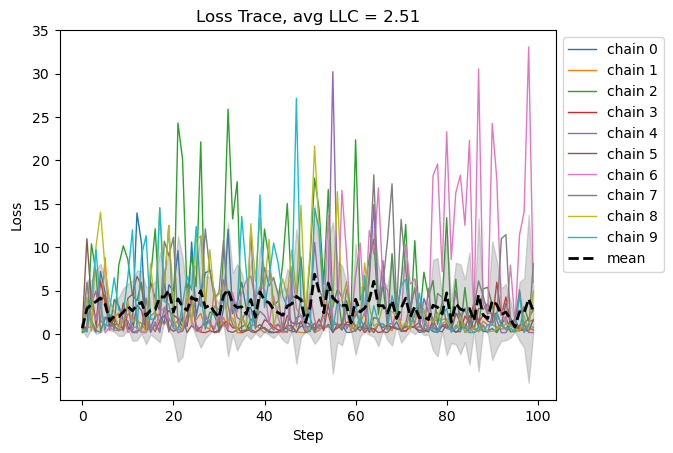

<Figure size 1200x900 with 0 Axes>

In [9]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)